In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy.special import digamma, gammaln, multigammaln
% matplotlib inline
from scipy.stats import beta,binom

In [2]:
# load data
X = np.genfromtxt('X.csv', delimiter = ',')
N = X.shape[0]

In [3]:
def update_pi_and_theta(phi, alpha0, a0, b0, X):
    n = np.sum(phi, axis=0)
    alpha = alpha0 + n
    a = a0 + np.sum((phi.T * X), 1)
    a = a.T
    b = b0 + np.sum((phi.T * (20 - X) ), axis = 1)
    b = b.T
    
    return alpha, a, b

In [4]:
def update_phi(phi, X, N, K, alpha, a, b):
    p1 = digamma(alpha)-digamma(np.sum(alpha))
    #p1 = p1.reshape((K,1))
    p2 = digamma(a)-digamma(a+b)
    #p2 = p2.reshape((K,1))
    p3 = digamma(b)-digamma(a+b)
    #p3 = p3.reshape((K,1))
    
    for i in range(N):
        phi[i,:] = np.exp(p1 + X[i]* p2 +(20-X[i])* p3)
        bot = np.sum(phi[i,:])
        phi[i,:] = phi[i,:]/bot

#     print("-------------phi-----------------")
#     print(phi)
     
    return phi

In [5]:
def ln_p(alpha, alpha0, X, K, a, b, a0, b0, phi, pi):
    #first term p phix
    p1 = digamma(alpha)-digamma(np.sum(alpha))
    p2 = digamma(a)-digamma(a+b)    
    p3 = digamma(b)-digamma(a+b)

    p1p2 = 0
    for i in range(len(X)):
        p1p2 += np.sum(phi[i,:]*(p1 + X[i]*p2 + (20-X[i])*p3))

    #second term p piphi
    p2 = np.sum(phi@pi, 0)[0]
    p2 = 0
    
    #third term p theta
    p3 = np.sum(gammaln(a0+b0)- gammaln(a0) - gammaln(b0) + \
                (digamma(a)- digamma(a+b))*(a0-1) + (digamma(b) - digamma(a+b))*(b0-1))
    
    #fourth term p pi
    p4 = gammaln(np.sum(alpha0)) - np.sum(gammaln(alpha0))
    p4 += np.sum((alpha0-1) * (digamma(alpha) - digamma(np.sum(alpha))))
    
    result = p1p2+p3+p4
    return result

In [6]:
def entropy(alpha, phi, a, b):
    #fifth term qpi
    p5 = gammaln(np.sum(alpha))-np.sum(gammaln(alpha))
    p5 += np.sum((alpha-1) * (digamma(alpha)-digamma(np.sum(alpha))))
    
    #sixth term qc
    pt6 = np.sum(phi * np.log(phi))
    
    #seventh term qtheta
    pt7 = np.sum(gammaln(a+b)-gammaln(a)-gammaln(b)+(a-1)* \
                 (digamma(a)-digamma(a+b))+(b-1)*(digamma(b)-digamma(a+b)))
    
    result = p5+pt6+pt7
    return result

In [7]:
def VI(X, N, K, a0, b0, a, b, alpha0, alpha, pi, phi, likelihood_list):
    #update parameters
    alpha, a, b = update_pi_and_theta(phi, alpha0, a0, b0, X)
    phi = update_phi(phi, X, N, K, alpha, a, b)
    
    lnp = ln_p(alpha, alpha0, X, K, a, b, a0, b0, phi, pi)
    entro = entropy(alpha, phi, a, b)
    obj_fcn = lnp - entro
    
    return phi, a, b, alpha, obj_fcn

In [8]:
def call(X, K=3, T=1000):
    #read dimension
    N = X.shape[0]

    #initialization with p 
    alpha0 = np.ones(K, dtype = 'float')/10
    a0 = b0 = np.ones(K, dtype = 'float')/2

    #initialization with q
    #theta = np.array([0.01 * (i+1) for i in range(K)]).reshape((K,1))
    pi = np.array([0.01 * (i+1) for i in range(K)]).reshape((K,1))

    phi = np.random.random((N,K))
    
    alpha = np.ones(K)/10
    a = b = np.ones(K, dtype = 'float')/2
    
    likelihood_list =[]
    
    for i in range(T):
        phi, a, b, alpha, likelihood = VI(X, N, K, a0, b0, a, b, alpha0, alpha, pi, phi, likelihood_list)
#         print("-----------------call iterations-----------------")
#         print(a,b)
        likelihood_list.append(likelihood)
        
    return phi, likelihood_list

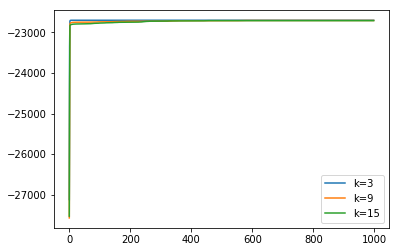

In [9]:
K = [3,9,15]

for k in K:
#     print(k)
    phi, L = call(X, K = k)
    plt.plot(L[1:],label="k=%d"%(k,))
#     plt.legend(loc='best')
#     plt.show()
plt.legend(loc='best')
plt.show()

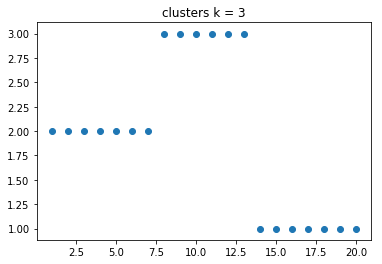

In [10]:
k = 3
phi1, L1 = call (X, K = k)
plot1 = [[0 for i in range(k)] for i in range(21)]
for j in range(1,21):
    for i in range(N):
        if int(X[i]) ==j:
            plot1[j][np.argmax(phi1[i,:])] += 1
#remove the first row
plot11 = plot1[1:]
for i in range(len(plot11)):
    plot11[i]= np.argmax(plot11[i]) +1
#plot
plt.scatter(range(1,21),plot11)
plt.title("clusters k = 3")
plt.show()

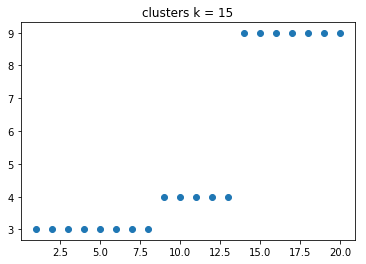

In [11]:
k = 15
phi2, L2 = call (X, K = k)
plot2 = [[0 for i in range(k)] for i in range(21)]
for j in range(1,21):
    for i in range(N):
        if int(X[i]) ==j:
            plot2[j][np.argmax(phi2[i,:])] += 1
#remove the first row
plot22 = plot2[1:]
for i in range(len(plot22)):
    plot22[i]= np.argmax(plot22[i]) +1 
#plot
plt.scatter(range(1,21),plot22)
plt.title("clusters k = 15")
plt.show()

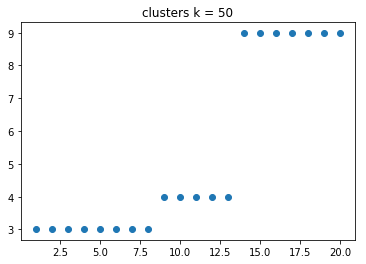

In [12]:
k = 50
phi3, L3 = call(X, K = k)
plot3 = [[0 for i in range(k)] for i in range(21)]
for j in range(1,21):
    for i in range(N):
        if int(X[i]) ==j:
            plot3[j][np.argmax(phi3[i,:])] += 1
#remove the first row
plot33 = plot3[1:]
for i in range(len(plot33)):
    plot33[i]= np.argmax(plot33[i]) +1 
#plot
plt.scatter(range(1,21),plot22)
plt.title("clusters k = 50")
plt.show()